In [157]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
import itertools as it
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [158]:
Path = os.getcwd()
print(Path)

f:\Projects\Main\Enhanced-Opposing-Properties-ML


In [159]:
Element_Features_Data = pd.read_excel(Path + '/Element_Features_Data.xlsx')
Composition_Properties_Data = pd.read_excel(Path + '/Composition_Properties_Data.xlsx')


In [160]:
npEFD = (Element_Features_Data.to_numpy())
npCPD = (Composition_Properties_Data.to_numpy())

In [161]:
np.random.shuffle(npCPD)

In [162]:
EFD_vals=npEFD[:,1:]
print(EFD_vals.shape)
print(EFD_vals)

CPD_comp = npCPD[:,1:-2]
CPD_op = npCPD[:,-2]


(69, 7)
[[29.0 50.0 30.0 28.0 82.0 15.0 12.0]
 [78.0 63.0 79.0 77.0 45.0 90.0 87.0]
 [26.0 41.0 25.0 27.0 59.0 14.0 17.0]
 [75.0 54.0 74.0 76.0 22.0 89.0 92.0]
 [4.0 5.0 4.0 4.0 6.0 3.0 3.0]
 [63.546 118.71 65.39 58.69 207.2 30.974 24.305]
 [50.9 31.1 55.4 46.6 120.0 7.89 4.11]
 [166.0 662.0 189.0 144.0 579.0 229.0 121.0]
 [53.0 256.0 60.3 45.7 232.0 74.1 38.6]
 [103.0 451.0 117.0 88.6 402.0 142.0 74.8]
 [1.45 2.24 1.49 1.41 3.28 0.341 0.288]
 [1.08 1.88 1.44 1.76 1.92 2.32 1.31]
 [1.9 1.8 1.6 1.9 1.9 2.1 1.2]
 [1.75 1.72 1.66 1.75 1.55 2.06 1.23]
 [4.48 4.3 4.45 4.4 3.9 5.62 8.3]
 [745.4 708.6 906.4 736.7 715.5 1011.7 737.7]
 [1958.0 1412.0 1733.0 1753.0 1450.0 1903.0 1451.0]
 [3554.0 2943.0 3833.0 3393.0 3081.0 2912.0 7733.0]
 [4.45 4.15 4.1 5.2 4.1 5.55 3.45]
 [4.6 4.4 4.2 5.1 4.0 0.0 3.7]
 [1.47 1.24 1.32 1.75 1.15 1.65 1.17]
 [4.2 5.65 4.35 4.05 5.65 4.8 2.85]
 [5.84 9.1 5.97 5.71 12.29 4.89 3.31]
 [118.4 107.3 0.0 112.0 35.1 72.0 0.0]
 [11.0 4.0 12.0 10.0 4.0 5.0 2.0]
 [11.0 4.0 

In [163]:
fmv = np.zeros((27,69,2))

In [164]:
def get_al_factor(al_num, feat_num):#al_num is the number of the alloy from composition, feat_num is the number of the feature from EFD
    al = CPD_comp[al_num]
    num = 0
    denom = 0
    for i, ele_comp in enumerate(al):
        num += ele_comp * EFD_vals[feat_num][i]
        denom += ele_comp
    key_mean = num/denom

    num = 0
    for i, ele_comp in enumerate(al):
        num += ele_comp * ((EFD_vals[feat_num][i] - key_mean)**2)
    key_vari = num/denom
    return key_mean, key_vari

In [165]:
for al in range(27):
    for feat in range(69):
        fmv[al][feat][0], fmv[al][feat][1] = get_al_factor(al, feat)

0 is mean 1 is variance

In [166]:
split = 22

In [167]:
print(fmv.shape)

(27, 69, 2)


In [168]:
train_set = npCPD[:split]
test_set  = npCPD[split:]


In [169]:
rain_comp = train_set[:,1:-2]
train_prop = train_set[:,-2:]

test_comp = test_set[:,1:-2]
test_prop = test_set[:,-2:]

In [170]:
lin_fmv = fmv.reshape((27,138))
train_fmv = lin_fmv[:split, :]
test_fmv = lin_fmv[split:,:]

In [171]:
avg_fmv = np.mean(train_fmv, axis = 0)
print(avg_fmv.shape)

(138,)


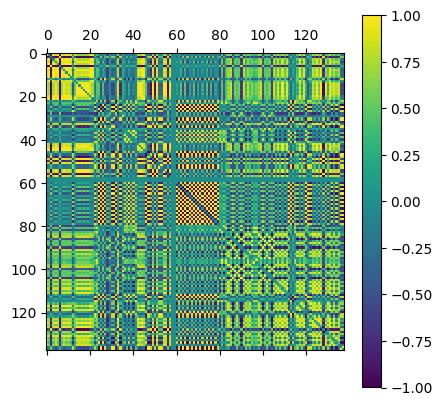

In [172]:
r = np.zeros((138,138))
for i in range(138):
    # r[i][i] = 1
    for j in range((i+1),138):
        num = 0
        denomi = 1e-9
        denomj = 1e-9
        for al in range(split):
            num += (train_fmv[al][i] - avg_fmv[i]) * (train_fmv[al][j] - avg_fmv[j])
            denomi += (train_fmv[al][i] - avg_fmv[i])**2
            denomj += (train_fmv[al][j] - avg_fmv[j])**2
        r[i][j] = num/(math.sqrt(denomi) * math.sqrt(denomj))
        r[j][i] = r[i,j]

plt.matshow(r)
plt.colorbar()
# # plt.savefig('CorrelationMatrix-20230209-1904.png', dpi = 3000)
plt.show()


In [173]:
#screening correlation 
accountedfor = set()
sel = list()

for x in range(138):
    if x in accountedfor:
        continue
    accountedfor.add(x)
    for y in range(x,138):
        if abs(r[x][y]) > 0.95:
            accountedfor.add(y)
    sel.append(x)


In [174]:

sel1 = []

for x in range(138):
    if x in sel1:
        continue
    sel1.append(x)
    for y in range(x, 138):
        if abs(r[x][y]) > 0.95:
            sel1.append(y)


In [175]:
print(sel)
sel1.sort()
print(sel1)
print(accountedfor)

[0, 1, 2, 12, 14, 22, 23, 24, 27, 28, 29, 33, 34, 35, 36, 37, 39, 52, 56, 58, 59, 60, 80, 81, 84, 85, 87, 92, 93, 115, 116, 121, 128, 135]
[0, 1, 2, 3, 3, 4, 5, 5, 6, 7, 8, 8, 9, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 18, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 43, 44, 44, 44, 45, 45, 46, 47, 48, 49, 49, 50, 51, 51, 52, 53, 54, 54, 55, 55, 56, 57, 57, 57, 58, 59, 60, 61, 61, 62, 63, 64, 65, 65, 66, 67, 67, 68, 68, 69, 69, 70, 71, 71, 72, 73, 74, 74, 75, 75, 76, 76, 77, 78, 79, 79, 80, 81, 82, 83, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 94, 95, 96, 97, 98, 99, 100, 100, 101, 102, 102, 103, 104, 105, 106, 107, 107, 107, 108, 109, 109, 109, 110, 111, 111, 111, 112, 113, 113, 114, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 125, 125, 126, 126, 127, 127, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26

The line of code `mat = r[:, sel]` is using numpy's advanced indexing feature to select a subset of the data from the `r` array.

In this case, `r[:, sel]` is selecting all rows (indicated by the `:`) and the columns specified by the `sel` variable from the `r` array. 

The `sel` variable is expected to be an integer, a list of integers, or a boolean array, which specifies the indices of the columns to be selected. 

The result of this operation is then stored in the `mat` variable. So, `mat` will contain the data from the specified columns of `r`. This might be done if only certain columns of `r` are needed for further processing or analysis. 


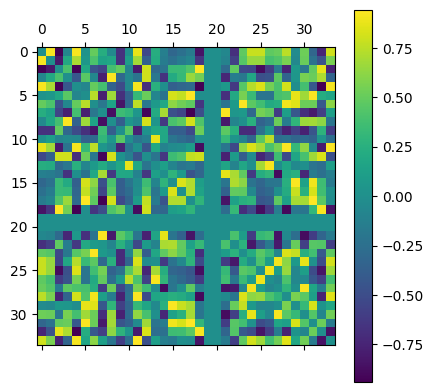

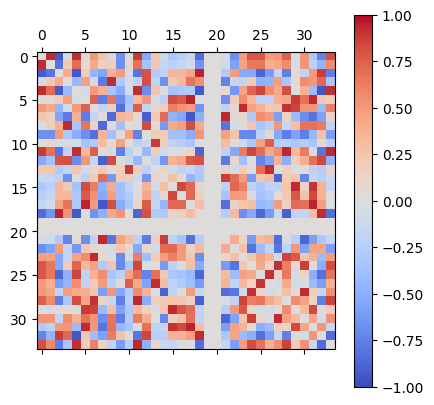

In [176]:
mat = r[:, sel]
mat = mat[sel, :]
plt.matshow(mat)
plt.colorbar()
plt.matshow(mat, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()


In [177]:
Prop_lab = []
for line in npEFD[:,0]:
    code = line.split()[0]

In [178]:
Prop_lab = []
for line in npEFD[:,0]:
    code = line.split()[0]
    # Prop_lab.append(code+'-M')
    # Prop_lab.append(code+'-V')
    Prop_lab.append('M-'+ code)
    Prop_lab.append('V-'+ code)

In [179]:
print(Prop_lab)

['M-A1', 'V-A1', 'M-A2', 'V-A2', 'M-A3', 'V-A3', 'M-A4', 'V-A4', 'M-A5', 'V-A5', 'M-A6', 'V-A6', 'M-A7', 'V-A7', 'M-A8', 'V-A8', 'M-A9', 'V-A9', 'M-A10', 'V-A10', 'M-A11', 'V-A11', 'M-E1', 'V-E1', 'M-E2', 'V-E2', 'M-E3', 'V-E3', 'M-E4', 'V-E4', 'M-E5', 'V-E5', 'M-E6', 'V-E6', 'M-E7', 'V-E7', 'M-E8', 'V-E8', 'M-E9', 'V-E9', 'M-E10', 'V-E10', 'M-E11', 'V-E11', 'M-E12', 'V-E12', 'M-E13', 'V-E13', 'M-G1', 'V-G1', 'M-G2', 'V-G2', 'M-G3', 'V-G3', 'M-G4', 'V-G4', 'M-G5', 'V-G5', 'M-G6', 'V-G6', 'M-C1', 'V-C1', 'M-C2', 'V-C2', 'M-C3', 'V-C3', 'M-C4', 'V-C4', 'M-C5', 'V-C5', 'M-C6', 'V-C6', 'M-C7', 'V-C7', 'M-C8', 'V-C8', 'M-C9', 'V-C9', 'M-C10', 'V-C10', 'M-C11', 'V-C11', 'M-C12', 'V-C12', 'M-N1', 'V-N1', 'M-N2', 'V-N2', 'M-N3', 'V-N3', 'M-N4', 'V-N4', 'M-N5', 'V-N5', 'M-N6', 'V-N6', 'M-N7', 'V-N7', 'M-N8', 'V-N8', 'M-N9', 'V-N9', 'M-N10', 'V-N10', 'M-N11', 'V-N11', 'M-N12', 'V-N12', 'M-N13', 'V-N13', 'M-N14', 'V-N14', 'M-S1', 'V-S1', 'M-S2', 'V-S2', 'M-S3', 'V-S3', 'M-S4', 'V-S4', 'M-S5', 'V-

In [180]:
#"lab here reffers to lables"
sel_lab = []

for keynum in (sel):
    sel_lab.append(Prop_lab[keynum])
print(sel_lab)


['M-A1', 'V-A1', 'M-A2', 'M-A7', 'M-A8', 'M-E1', 'V-E1', 'M-E2', 'V-E3', 'M-E4', 'V-E4', 'V-E6', 'M-E7', 'V-E7', 'M-E8', 'V-E8', 'V-E9', 'M-G3', 'M-G5', 'M-G6', 'V-G6', 'M-C1', 'M-C11', 'V-C11', 'M-N1', 'V-N1', 'V-N2', 'M-N5', 'V-N5', 'V-S2', 'M-S3', 'V-S5', 'M-S9', 'V-S12']


In [181]:
#training the model
svrUTS = make_pipeline(StandardScaler(), SVR())
svrUTS.fit(train_fmv, train_prop[:,0])
test_op_UTS = svrUTS.predict(test_fmv)
train_op_UTS = svrUTS.predict(train_fmv)

svrEC = make_pipeline(StandardScaler(), SVR())
svrEC.fit(train_fmv, train_prop[:,1])
test_op_EC = svrEC.predict(test_fmv)
train_op_EC = svrEC.predict(train_fmv)

In [182]:
#errors in the model

In [183]:
# Full Model Error
FME_UTS_train = cross_val_score(estimator = svrUTS, X = train_fmv, y = train_prop[:, 0], cv = 10, scoring = "neg_mean_absolute_percentage_error")
FME_EC_train = cross_val_score(estimator = svrEC, X = train_fmv, y = train_prop[:, 1], cv = 10, scoring = "neg_mean_absolute_percentage_error")

UTS_train_scoravg = np.average(FME_UTS_train)
EC_train_scoravg = np.average(FME_EC_train)

FME_UTS_test = cross_val_score(estimator = svrUTS, X = test_fmv, y = test_prop[:, 0], cv = 2, scoring = "neg_mean_absolute_percentage_error")
FME_EC_test = cross_val_score(estimator = svrEC, X = test_fmv, y = test_prop[:, 1], cv = 2, scoring = "neg_mean_absolute_percentage_error")

UTS_test_scoravg = np.average(FME_UTS_test)
EC_test_scoravg = np.average(FME_EC_test)

train_mae_UTS = metrics.mean_absolute_error(train_prop[:,0], train_op_UTS)
train_mse_UTS = metrics.mean_squared_error(train_prop[:,0], train_op_UTS)
train_r2_UTS = metrics.r2_score(train_prop[:,0], train_op_UTS)

train_mae_EC = metrics.mean_absolute_error(train_prop[:,1], train_op_EC)
train_mse_EC = metrics.mean_squared_error(train_prop[:,1], train_op_EC)
train_r2_EC = metrics.r2_score(train_prop[:,1], train_op_EC)

test_mae_UTS = metrics.mean_absolute_error(test_prop[:,0], test_op_UTS)
test_mse_UTS = metrics.mean_squared_error(test_prop[:,0], test_op_UTS)
test_r2_UTS = metrics.r2_score(test_prop[:,0], test_op_UTS)

test_mae_EC = metrics.mean_absolute_error(test_prop[:,1], test_op_EC)
test_mse_EC = metrics.mean_squared_error(test_prop[:,1], test_op_EC)
test_r2_EC = metrics.r2_score(test_prop[:,1], test_op_EC)


In [184]:
print("**********Full Model Error**********")
print(f"---svrUTS---\nTrain\nCV - {UTS_train_scoravg}\nMAE - {train_mae_UTS}\nMSE - {train_mse_UTS}\nR2 - {train_r2_UTS}\nTest\nCV  - {UTS_test_scoravg}\nMAE - {test_mae_UTS}\nMSE - {test_mse_UTS}\nR2 - {test_r2_UTS}")
print()
print(f"---svrEC---\nTrain\nCV - {EC_train_scoravg}\nMAE - {train_mae_EC}\nMSE - {train_mse_EC}\nR2 - {train_r2_EC}\nTest\nCV  - {EC_test_scoravg}\nMAE - {test_mae_EC}\nMSE - {test_mse_EC}\nR2 - {test_r2_EC}")
print("************************************")


**********Full Model Error**********
---svrUTS---
Train
CV - -0.11047775853489097
MAE - 31.256067602069265
MSE - 1751.679620439228
R2 - 0.052109760065353616
Test
CV  - -0.11241675567924128
MAE - 28.584782342937842
MSE - 1253.671293621664
R2 - 0.0018540655878470647

---svrEC---
Train
CV - -0.5238813374317701
MAE - 8.07551071460059
MSE - 161.29528017096132
R2 - 0.15599684740156017
Test
CV  - -0.16925973351457496
MAE - 2.845854798812603
MSE - 23.806304596308163
R2 - 0.17795909543134802
************************************


In [185]:
sel_alfeat = lin_fmv[:,sel]
print(sel_alfeat.shape)


train_sel_alfeat = sel_alfeat[:split, :]
test_sel_alfeat = sel_alfeat[split:,:]

scaler = StandardScaler()
scaler.fit(train_sel_alfeat)
train_sel_alfeat = scaler.transform(train_sel_alfeat)
test_sel_alfeat = scaler.transform(test_sel_alfeat)

non_corr_UTS = SVR(kernel = 'rbf')
non_corr_EC = SVR(kernel = 'rbf')

(27, 34)


In [186]:
def printscore(model, x, y, printtrue = True):
    MAPE = metrics.mean_absolute_percentage_error(y, model.predict(x))
    MAE = metrics.mean_absolute_error(y, model.predict(x))
    MSE = metrics.mean_squared_error(y, model.predict(x))
    R2 = metrics.r2_score(y, model.predict(x))
    if printtrue:
        print(f"MAPE - {metrics.mean_absolute_percentage_error(y, model.predict(x))}")
        print(f"MAE - {metrics.mean_absolute_error(y, model.predict(x))}")
        print(f"MSE - {metrics.mean_squared_error(y, model.predict(x))}")
        print(f"R2 - {metrics.r2_score(y, model.predict(x))}")

    return MAPE, MAE, MSE, R2

In [187]:
non_corr_UTS.fit(train_sel_alfeat, train_prop[:,0])
non_corr_EC.fit(train_sel_alfeat, train_prop[:,1])

SVR()

In [188]:
print("UTS")
_ , _, NCUTS, _ = printscore(non_corr_UTS, train_sel_alfeat, train_prop[:, 0])
print("EC")
_, _, NCEC, _ = printscore(non_corr_EC, train_sel_alfeat, train_prop[:, 1])

end = False
UTS_RE = train_sel_alfeat.copy()
UTS_RE_SEL = sel.copy()
EC_RE = train_sel_alfeat.copy()
EC_RE_SEL = sel.copy()


UTS
MAPE - 0.09850413724387747
MAE - 31.055997812610062
MSE - 1736.7782958273622
R2 - 0.06017334657790541
EC
MAPE - 0.44137245292877547
MAE - 7.864190938796454
MSE - 157.88773897804364
R2 - 0.1738273475028853


In [189]:
print(UTS_RE_SEL)

[0, 1, 2, 12, 14, 22, 23, 24, 27, 28, 29, 33, 34, 35, 36, 37, 39, 52, 56, 58, 59, 60, 80, 81, 84, 85, 87, 92, 93, 115, 116, 121, 128, 135]


In [190]:
UTSscore = {}
for n_sel in range(1, len(UTS_RE_SEL)):
# for n_sel in range(6, 7):
    modsvr = SVR(kernel = "linear")
    modrfe = RFE(estimator = modsvr, n_features_to_select = n_sel)
    modrfe.fit(train_sel_alfeat, train_prop[:, 0])
    print(n_sel)

    print("Selected Features: ", modrfe.support_)

    xtrain = modrfe.transform(train_sel_alfeat)
    xtest = modrfe.transform(test_sel_alfeat)

    modsvr.fit(xtrain, train_prop[:, 0])

    # ytrain = modsvr.predict(xtrain)
    # ytest = modsvr.predict(xtest)

    print("Train Error")
    _, mtra, _, _ = printscore(modsvr, xtrain, train_prop[:, 0])
    print("Test Error")
    _, mtes, _, _ = printscore(modsvr, xtest, test_prop[:, 0])

    UTSscore[n_sel] = [mtra, mtes]
    print()

1
Selected Features:  [False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False]
Train Error
MAPE - 0.08110399763084795
MAE - 26.156524641908277
MSE - 1298.939244070999
R2 - 0.297102154208853
Test Error
MAPE - 0.08560361055764112
MAE - 26.25148088514809
MSE - 881.0901026501633
R2 - 0.2984951412020993

2
Selected Features:  [False False False False False False  True False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False]
Train Error
MAPE - 0.06644808630768796
MAE - 21.177180464595928
MSE - 895.3653727361902
R2 - 0.5154889695072946
Test Error
MAPE - 0.07054350643263507
MAE - 21.65771733726451
MSE - 596.6797365683575
R2 - 0.524936515471053

3
Selected Features:  [False False False False False False  True False False False False False
 

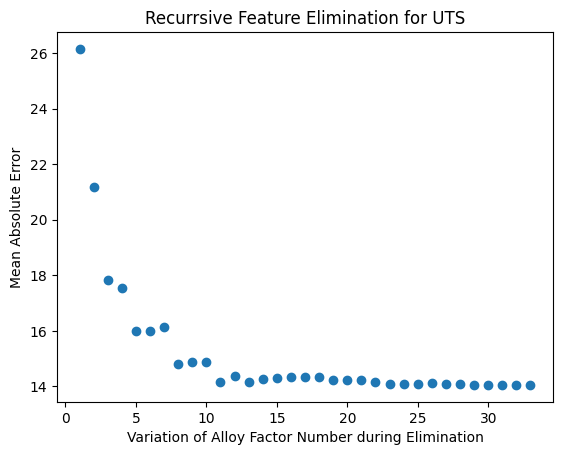

In [191]:

plt.scatter(UTSscore.keys(), [UTSscore[i][0] for i in UTSscore.keys()])
plt.xlabel("Variation of Alloy Factor Number during Elimination")
plt.ylabel("Mean Absolute Error")
plt.title("Recurrsive Feature Elimination for UTS")
plt.show()


In [192]:
for i in UTSscore.keys():
    print(f"{i} : {UTSscore[i]}")

def smallest_value(input_dict):
    if not input_dict:
        return []
    min_first_value = min(input_dict.values(), key=lambda x: x[0])[0]
    keys = [key for key, (value1, value2) in input_dict.items() if value1 == min_first_value]
    return keys


1 : [26.156524641908277, 26.25148088514809]
2 : [21.177180464595928, 21.65771733726451]
3 : [17.84050498467411, 18.934334126177497]
4 : [17.536122983592417, 15.634495377831115]
5 : [15.990146122496283, 12.687676543519444]
6 : [15.978575387409249, 12.32647759746144]
7 : [16.125623777948885, 12.851243546405954]
8 : [14.79238369437307, 11.921864995900853]
9 : [14.88801993342891, 13.826395576273057]
10 : [14.858103089529699, 11.996181420784172]
11 : [14.141165936313405, 12.022315248918323]
12 : [14.372826396126454, 13.302401101457496]
13 : [14.16741969517379, 12.523212976903835]
14 : [14.251516507132614, 12.503223363945404]
15 : [14.302405747762386, 12.35163014816394]
16 : [14.336598637339005, 12.383433830998069]
17 : [14.335719573656739, 12.340304130981156]
18 : [14.340249926020446, 12.326202089113053]
19 : [14.217081260309245, 12.008226323579526]
20 : [14.239614829765607, 12.00065635967976]
21 : [14.226650900262324, 11.956875892649418]
22 : [14.147751570914114, 11.691521326792008]
23 : [

In [193]:
UTS_nsel = smallest_value(UTSscore)[0]
print(UTS_nsel)


32


In [194]:
ECscore = {}
for n_sel in range(1, len(EC_RE_SEL)):
# for n_sel in range(7, 8):
    modsvr = SVR(kernel = "linear")
    modrfe = RFE(estimator = modsvr, n_features_to_select = n_sel)
    modrfe.fit(train_sel_alfeat, train_prop[:, 1])
    print(n_sel)

    print("Selected Features: ", modrfe.support_)

    xtrain = modrfe.transform(train_sel_alfeat)
    xtest = modrfe.transform(test_sel_alfeat)

    modsvr.fit(xtrain, train_prop[:, 1])
    print("Train Error")
    _, mtra, _, _ = printscore(modsvr, xtrain, train_prop[:, 1])
    print("Test Error")
    _, mtes, _, _ = printscore(modsvr, xtest, test_prop[:, 1])

    ECscore[n_sel] = [mtra, mtes]
    print()



1
Selected Features:  [False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
Train Error
MAPE - 0.2921196130240233
MAE - 5.97173706250182
MSE - 90.52577680072092
R2 - 0.5263095055834963
Test Error
MAPE - 0.07152200976437093
MAE - 2.4011901658704438
MSE - 10.875787891489349
R2 - 0.6244548380010584

2
Selected Features:  [False False False False False False  True False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False]
Train Error
MAPE - 0.19797023646666645
MAE - 4.271096316840676
MSE - 41.229788682467465
R2 - 0.7842585871571284
Test Error
MAPE - 0.06739079162489332
MAE - 2.2515461040083977
MSE - 8.647248983460894
R2 - 0.701407148361157

3
Selected Features:  [False False False False False False  True False False False  True False


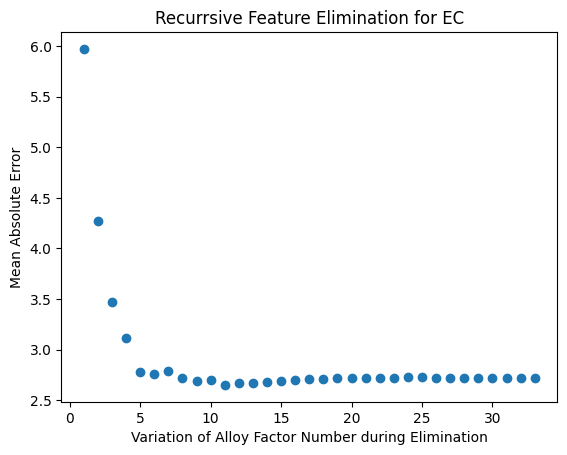

In [195]:
plt.scatter(ECscore.keys(), [ECscore[i][0] for i in ECscore.keys()])
plt.xlabel("Variation of Alloy Factor Number during Elimination")
plt.ylabel("Mean Absolute Error")
plt.title("Recurrsive Feature Elimination for EC")
plt.show()

In [196]:
for i in ECscore.keys():
    print(f"{i} : {ECscore[i]}")

EC_nsel = smallest_value(ECscore)[0]
print(EC_nsel)

UTSmod = SVR(kernel = "linear")
UTSmodrfe = RFE(estimator = UTSmod, n_features_to_select = UTS_nsel)
UTSmodrfe.fit(train_sel_alfeat, train_prop[:, 0])
UTSsupp = (UTSmodrfe.support_)
print(UTSsupp)


1 : [5.97173706250182, 2.4011901658704438]
2 : [4.271096316840676, 2.2515461040083977]
3 : [3.466885659532547, 2.1723152657882197]
4 : [3.117664101687787, 2.5058790508361306]
5 : [2.7781309988864744, 2.3628311746340054]
6 : [2.7595457948632736, 2.4622119841604038]
7 : [2.7838775193189425, 2.518313720876699]
8 : [2.719081502552461, 2.4095906100480926]
9 : [2.6859137527752917, 2.510195781998649]
10 : [2.7031104841780054, 2.551789351958599]
11 : [2.6501018823207825, 2.4224420410123164]
12 : [2.6738035942452676, 2.456008615341184]
13 : [2.671295295450204, 2.457959623619318]
14 : [2.6768204935074844, 2.4385249779991227]
15 : [2.6871284935188884, 2.439049449213281]
16 : [2.7002976889125225, 2.4241431040305548]
17 : [2.705751080752549, 2.381518861557695]
18 : [2.7058264176817506, 2.389786593930732]
19 : [2.714080962894251, 2.4059112551131845]
20 : [2.7226986831011515, 2.3767389827564087]
21 : [2.7217680772094943, 2.3983272558027315]
22 : [2.719357899495593, 2.38722002634127]
23 : [2.723175446

In [197]:
UTSrefsel = []
for i in range(len(UTSsupp)):
     if UTSmodrfe.support_[i]:
         UTSrefsel.append(UTS_RE_SEL[i])

ECmod = SVR(kernel = "linear")
ECmodrfe = RFE(estimator = ECmod, n_features_to_select = EC_nsel)
ECmodrfe.fit(train_sel_alfeat, train_prop[:, 1])
ECsupp = (ECmodrfe.support_)
print(ECsupp)


[False False False  True False False  True False False False  True  True
 False  True False False  True False False False False False False  True
 False False False False  True  True False  True False  True]


In [198]:
ECrefsel = []
for i in range(len(ECsupp)):
     if ECmodrfe.support_[i]:
         ECrefsel.append(EC_RE_SEL[i])

print(UTSrefsel)
print(ECrefsel)

[0, 1, 2, 12, 14, 22, 23, 24, 27, 28, 29, 33, 34, 35, 36, 37, 39, 52, 56, 60, 80, 81, 84, 85, 87, 92, 93, 115, 116, 121, 128, 135]
[12, 23, 29, 33, 35, 39, 81, 93, 115, 121, 135]


In [199]:
print("\nUTS")
for i in range(len(UTSrefsel)):
    print(Prop_lab[UTSrefsel[i]])
print("\nEC")
for i in range(len(ECrefsel)):
    print(Prop_lab[ECrefsel[i]])

print("\nUTS")
for i in range(len(UTSrefsel)):
    print(UTSrefsel[i], Prop_lab[UTSrefsel[i]], end = "- ")
    for j in range(138):
        if abs(r[UTSrefsel[i]][j]) > 0.95:
            print(Prop_lab[j], end=" ")
    print()
print("\nEC")
for i in range(len(ECrefsel)):
    print(ECrefsel[i], Prop_lab[ECrefsel[i]], end = "- ")
    for j in range(138):
        if abs(r[ECrefsel[i]][j]) > 0.95:
            print(Prop_lab[j], end=" ")
    print()
print(UTSrefsel)
print(ECrefsel)


UTS
M-A1
V-A1
M-A2
M-A7
M-A8
M-E1
V-E1
M-E2
V-E3
M-E4
V-E4
V-E6
M-E7
V-E7
M-E8
V-E8
V-E9
M-G3
M-G5
M-C1
M-C11
V-C11
M-N1
V-N1
V-N2
M-N5
V-N5
V-S2
M-S3
V-S5
M-S9
V-S12

EC
M-A7
V-E1
V-E4
V-E6
V-E7
V-E9
V-C11
V-N5
V-S2
V-S5
V-S12

UTS
0 M-A1- V-A2 V-A3 M-A4 M-A5 V-A5 M-A6 M-A11 M-E12 V-E12 V-S3 V-S4 V-S7 V-S8 V-S10 
1 V-A1- V-A2 V-A3 V-A4 V-A5 V-A6 V-A7 V-A11 V-E12 
2 M-A2- M-A3 M-A5 V-A9 V-A10 V-E11 M-E12 V-G1 V-G2 M-G4 V-G4 V-G5 V-S7 V-S8 
12 M-A7- 
14 M-A8- M-A5 V-A8 M-A9 V-A9 M-A10 V-A10 M-E11 V-E11 M-E12 V-G1 V-G2 M-G4 V-G4 V-G5 V-N13 V-S7 V-S8 
22 M-E1- M-E6 V-C1 V-C4 V-C6 V-C10 V-S1 M-S2 
23 V-E1- V-C12 
24 M-E2- V-E2 M-E3 M-E5 V-E5 M-E13 V-E13 M-C2 V-C2 M-C3 V-C3 M-C5 V-C5 M-C8 V-C8 M-C9 M-S13 V-S13 
27 V-E3- 
28 M-E4- 
29 V-E4- 
33 V-E6- V-N12 V-N13 V-N14 V-S6 V-S11 
34 M-E7- M-G1 M-G2 M-S11 M-S12 
35 V-E7- 
36 M-E8- M-E9 M-E10 
37 V-E8- V-E10 
39 V-E9- 
52 M-G3- V-G3 V-C1 V-C3 V-C4 V-C5 V-C6 V-C7 V-C8 V-C9 V-C10 V-S1 M-S2 
56 M-G5- V-A8 V-A9 V-A10 V-E11 V-G1 V-G2 M-G4 V-G4 V-G

In [200]:

UTScombs = []
for r in range(1, len(UTSrefsel) + 1):
    UTScombs.extend(it.combinations(UTSrefsel, r))

ECcombs = []
for r in range(1, len(ECrefsel) + 1):
    ECcombs.extend(it.combinations(ECrefsel, r))

UTStrain = UTSmodrfe.transform(train_sel_alfeat)
ECtrain = ECmodrfe.transform(train_sel_alfeat)

errdat = []
xdat = []

MemoryError: 

In [ ]:
for i in range(len(UTScombs)):
    xdat.append(len(UTScombs[i]))
    take = [a in UTScombs[i] for a in (UTSrefsel)]
    take = np.where(take)[0]
    # print(take)
    model = SVR(kernel = "linear")
    model.fit(UTStrain[:, take], train_prop[:, 0])
    _, err, _, _ = printscore(model, UTStrain[:, take], train_prop[:, 0], printtrue = False)
    errdat.append(err)


KeyboardInterrupt: 

In [ ]:
plt.scatter(xdat, errdat)
plt.xlabel("Variation of Alloy Factor Number during Screening")
plt.ylabel("Mean Absolute Error")
plt.title("Exhaustive Screening for UTS")
plt.show()



KeyboardInterrupt: 

In [ ]:
best_combUTS = UTScombs[np.argmin(errdat)]
print(best_combUTS)


In [ ]:
errdat = []
xdat = []

for i in range(len(ECcombs)):
    xdat.append(len(ECcombs[i]))
    take = [a in ECcombs[i] for a in (ECrefsel)]
    take = np.where(take)[0]
    # print(take)
    model = SVR(kernel = "linear")
    model.fit(ECtrain[:, take], train_prop[:, 1])
    _, err, _, _ = printscore(model, ECtrain[:, take], train_prop[:, 1], printtrue = False)
    errdat.append(err)


In [ ]:

plt.scatter(xdat, errdat)
plt.xlabel("Variation of Alloy Factor Number during Exhaustive Screening")
plt.ylabel("Mean Absolute Error")
plt.title("Exhaustive Screening for EC")
plt.show()


In [ ]:
best_combEC = ECcombs[np.argmin(errdat)]
print(best_combEC)

In [ ]:
print("\nSVR\n***UTS***")
finUTS = SVR(kernel = "linear")
finUTSTrain = UTSmodrfe.transform(train_sel_alfeat)
UTStake = [a in best_combUTS for a in (UTSrefsel)]
UTStake = np.where(UTStake)[0]
finUTS.fit(finUTSTrain[:, UTStake], train_prop[:, 0])
finUTSTest = UTSmodrfe.transform(test_sel_alfeat)
print("Training Score")
printscore(finUTS, finUTSTrain[:, UTStake], train_prop[:, 0])
print("\nTesting Score")
printscore(finUTS, finUTSTest[:, UTStake], test_prop[:, 0])


In [ ]:
plt.scatter(finUTS.predict(finUTSTrain[:, UTStake]), train_prop[:, 0], c = "blue", label = "Training Set")
plt.scatter(finUTS.predict(finUTSTest[:, UTStake]), test_prop[:, 0], c = "red", label = "Testing Set")
plt.legend()
plt.plot([200,500], [200,500], color = "gray")
plt.xlabel("Predicted UTS (MPa)")
plt.ylabel("Experimental UTS (MPa)")
plt.title("The performance of the final UTS model using SVR")
plt.show()

In [ ]:
print("***EC***")
finEC = SVR(kernel = "linear")
finECTrain = ECmodrfe.transform(train_sel_alfeat)
ECtake = [a in best_combEC for a in (ECrefsel)]
ECtake = np.where(ECtake)[0]
finEC.fit(finECTrain[:, ECtake], train_prop[:, 1])
finECTest = ECmodrfe.transform(test_sel_alfeat)
print("Training Score")
printscore(finEC, finECTrain[:, ECtake], train_prop[:, 1])
print("\nTesting Score")
printscore(finEC, finECTest[:, ECtake], test_prop[:, 1])
print("*************\n")


In [ ]:
plt.scatter(finEC.predict(finECTrain[:, ECtake]), train_prop[:, 1], c = "blue", label = "Training Set")
plt.scatter(finEC.predict(finECTest[:, ECtake]), test_prop[:, 1], c = "red", label = "Testing Set")
plt.legend()
plt.plot([0,100], [0,100], color = "gray")
plt.xlabel("Predicted EC (%IACS)")
plt.ylabel("Experimental EC (%IACS)")
plt.title("The performance of the final EC model using SVR")
plt.show()


In [ ]:
print("Bootstrap Aggregating\n***UTS***")
basebagUTS = DecisionTreeRegressor()
BAGUTS = BaggingRegressor(basebagUTS, n_estimators = 100)
BAGUTS.fit(finUTSTrain[:, UTStake], train_prop[:, 0])
print("Training Score")
printscore(BAGUTS, finUTSTrain[:, UTStake], train_prop[:, 0])
print("\nTesting Score")
printscore(BAGUTS, finUTSTest[:, UTStake], test_prop[:, 0])
print("***EC***")
basebagEC = DecisionTreeRegressor()
BAGEC = BaggingRegressor(basebagEC, n_estimators = 100)
BAGEC.fit(finECTrain[:, ECtake], train_prop[:, 1])
print("Training Score")
printscore(BAGEC, finECTrain[:, ECtake], train_prop[:, 1])
print("\nTesting Score")
printscore(BAGEC, finECTest[:, ECtake], test_prop[:, 1])
print("*************\n")


In [ ]:
plt.scatter(BAGUTS.predict(finUTSTrain[:, UTStake]), train_prop[:, 0], c = "blue", label = "Training Set")
plt.scatter(BAGUTS.predict(finUTSTest[:, UTStake]), test_prop[:, 0], c = "red", label = "Testing Set")
plt.legend()
plt.plot([200,500], [200,500], color = "gray")
plt.xlabel("Predicted UTS (MPa)")
plt.ylabel("Experimental UTS (MPa)")
plt.title("The performance of the final UTS model using Bagging Regressor")
plt.show()


In [ ]:
plt.scatter(BAGEC.predict(finECTrain[:, ECtake]), train_prop[:, 1], c = "blue", label = "Training Set")
plt.scatter(BAGEC.predict(finECTest[:, ECtake]), test_prop[:, 1], c = "red", label = "Testing Set")
plt.legend()
plt.plot([0,100], [0,100], color = "gray")
plt.xlabel("Predicted EC (%IACS)")
plt.ylabel("Experimental EC (%IACS)")
plt.title("The performance of the final EC model using Bagging Regressor")
plt.show()

In [ ]:
print("Random Forest\n***UTS***")
RFUTS = RandomForestRegressor(n_estimators = 100)
RFUTS.fit(finUTSTrain[:, UTStake], train_prop[:, 0])
print("Training Score")
printscore(RFUTS, finUTSTrain[:, UTStake], train_prop[:, 0])
print("\nTesting Score")
printscore(RFUTS, finUTSTest[:, UTStake], test_prop[:, 0])
print("***EC***")
RFEC = RandomForestRegressor(n_estimators = 100)
RFEC.fit(finECTrain[:, ECtake], train_prop[:, 1])
print("Training Score")
printscore(RFEC, finECTrain[:, ECtake], train_prop[:, 1])
print("\nTesting Score")
printscore(RFEC, finECTest[:, ECtake], test_prop[:, 1])
print("*************\n")


In [ ]:
plt.scatter(RFUTS.predict(finUTSTrain[:, UTStake]), train_prop[:, 0], c = "blue", label = "Training Set")
plt.scatter(RFUTS.predict(finUTSTest[:, UTStake]), test_prop[:, 0], c = "red", label = "Testing Set")
plt.legend()
plt.plot([200,500], [200,500], color = "gray")
plt.xlabel("Predicted UTS (MPa)")
plt.ylabel("Experimental UTS (MPa)")
plt.title("The performance of the final UTS model using Random Forest")
plt.show()


In [ ]:

plt.scatter(RFEC.predict(finECTrain[:, ECtake]), train_prop[:, 1], c = "blue", label = "Training Set")
plt.scatter(RFEC.predict(finECTest[:, ECtake]), test_prop[:, 1], c = "red", label = "Testing Set")
plt.legend()
plt.plot([0,100], [0,100], color = "gray")
plt.xlabel("Predicted EC (%IACS)")
plt.ylabel("Experimental EC (%IACS)")
plt.title("The performance of the final EC model using Random Forest")
plt.show()